# Can I predict which kind of product people will purchase?

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_and_wrangled.csv')

# Baselines


In [4]:
### My baselines:
df['Product'].value_counts(normalize=True)
### I want to predict what factors cause people to purchase accessories

Accessory    0.759163
Boat B       0.094369
Boat A       0.085662
Boat D       0.035529
Boat C       0.021064
Boat E       0.004213
Name: Product, dtype: float64

#### Accuracy could be misleading because of class imbalances.

# Wrangling

In [5]:
### Dropping an unneccesary column
df = df.drop(columns=['Unnamed: 0'])

###Turn dates into datetime objects
print(type(df['Date'][0]))
#df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
##Checking to make sure it worked
print(type(df['Date'][0]))

print(df.shape)
df.head(5)

<class 'numpy.int64'>
<class 'numpy.int64'>
(7121, 9)


,Transaction ID,Date,Product,Source,Count of Sessions,Quantity,Product Revenue,Landing Page,Device Category
0,#11963,20191231,Accessory,knoji.com,5,1,$25.00,/cart,desktop
1,#11963,20191231,Boat A,knoji.com,5,1,"$1,599.00",/cart,desktop
2,#11960,20191230,Boat C,affirm.com,3,1,"$2,199.00",/checkout/thank_you,mobile
3,#11960,20191230,Accessory,affirm.com,3,1,$99.00,/checkout/thank_you,mobile
4,#11960,20191230,Accessory,affirm.com,3,1,$110.00,/checkout/thank_you,mobile


In [6]:
##Turn prices into numbers not strings
print(type(df['Product Revenue'][0]))
df['Product Revenue'] = df['Product Revenue'].str.replace(',','')
df['Product Revenue'] = df['Product Revenue'].str.strip('[\$,]')

df['Product Revenue'] = pd.to_numeric(df['Product Revenue'])
print(type(df['Product Revenue'][0]))

display(df.head(5))

### Now that I did all that, I realize that I probably will have to drop the Revenue column becuase it's a form of data leakage.

<class 'str'>
<class 'numpy.float64'>


,Transaction ID,Date,Product,Source,Count of Sessions,Quantity,Product Revenue,Landing Page,Device Category
0,#11963,20191231,Accessory,knoji.com,5,1,25.0,/cart,desktop
1,#11963,20191231,Boat A,knoji.com,5,1,1599.0,/cart,desktop
2,#11960,20191230,Boat C,affirm.com,3,1,2199.0,/checkout/thank_you,mobile
3,#11960,20191230,Accessory,affirm.com,3,1,99.0,/checkout/thank_you,mobile
4,#11960,20191230,Accessory,affirm.com,3,1,110.0,/checkout/thank_you,mobile


# Visualizations

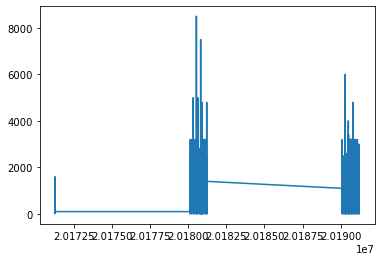

In [7]:
plt.plot(df['Date'], df['Product Revenue'])

### But at least it makes a nicer looking plot

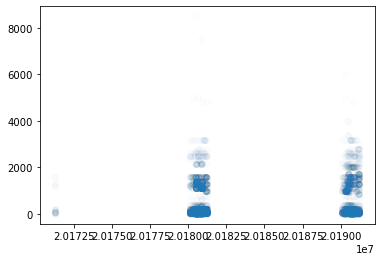

In [8]:
plt.scatter(df['Date'], df['Product Revenue'], alpha =.01);

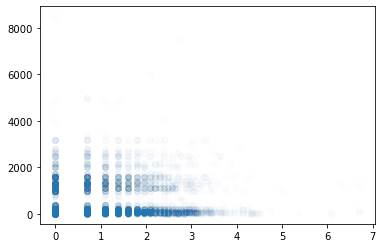

In [9]:
import numpy as np
plt.scatter(np.log(df['Count of Sessions']), df['Product Revenue'], alpha =.01);

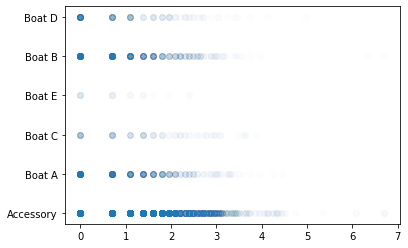

In [10]:
plt.scatter(np.log(df['Count of Sessions']), df['Product'], alpha =.01);

# Building a model

In [11]:
df.dtypes

Transaction ID        object
Date                   int64
Product               object
Source                object
Count of Sessions      int64
Quantity               int64
Product Revenue      float64
Landing Page          object
Device Category       object
dtype: object

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['Product'], random_state=42)

print(train.shape)
test.shape

(5696, 9)


(1425, 9)

## A simple Random Forest

In [14]:
# Arrange data into X features matrix and y target vector
target = 'Product'
X_train = train.drop(columns=target)
y_train = train[target]

X_test = test.drop(columns=target)
y_test = test[target]

In [15]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.9677192982456141


In [16]:
###NOTES: This doesn't like datetime objects. I commented it out above.

In [17]:
### Wow, test accuracy of .967! Probably because I have the price in there, ultimate data leakage!

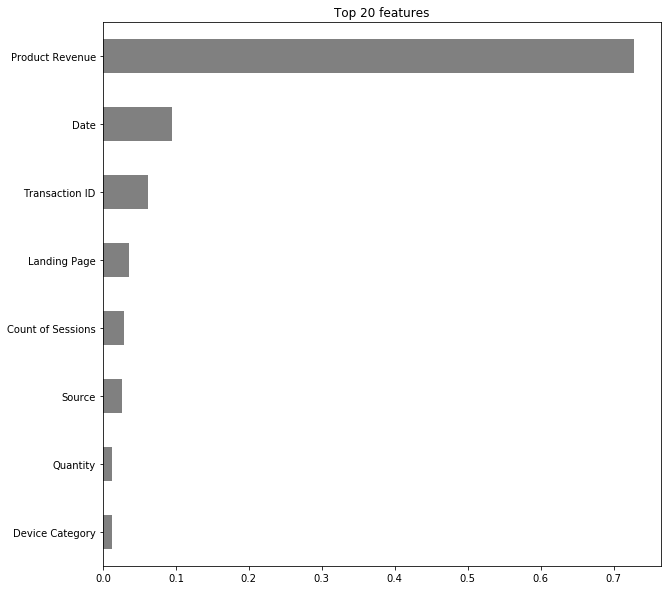

In [18]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');


###HAHAHA yes, turns out the revenue is a great predictor of what kind of product it is!

## Now for an XGBOOST

In [19]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Transaction ID', 'Source',
                                      'Landing Page', 'Device Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Transaction ID',
                                          'data_type': dtype('O'),
                                          'mapping': #9984        1
#10328       2
#11228       3
#9648        4
#10719       5
          ... 
#8112     3025
#8373     3026
#8495     3027
#10417    3028
NaN         -2
Length: 3029, dtyp...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                 

In [20]:

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

###Sick. I'm so accurate.

Validation Accuracy 0.9866666666666667


## Dropping 'Product Revenue' and re-running the models

In [21]:
df = df.drop(columns=['Product Revenue'])

In [22]:
df.head(5)

,Transaction ID,Date,Product,Source,Count of Sessions,Quantity,Landing Page,Device Category
0,#11963,20191231,Accessory,knoji.com,5,1,/cart,desktop
1,#11963,20191231,Boat A,knoji.com,5,1,/cart,desktop
2,#11960,20191230,Boat C,affirm.com,3,1,/checkout/thank_you,mobile
3,#11960,20191230,Accessory,affirm.com,3,1,/checkout/thank_you,mobile
4,#11960,20191230,Accessory,affirm.com,3,1,/checkout/thank_you,mobile


In [23]:
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['Product'], random_state=42)

print(train.shape)
test.shape

(5696, 8)


(1425, 8)

In [24]:
# Arrange data into X features matrix and y target vector
target = 'Product'
X_train = train.drop(columns=target)
y_train = train[target]

X_test = test.drop(columns=target)
y_test = test[target]

In [25]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.7080701754385965


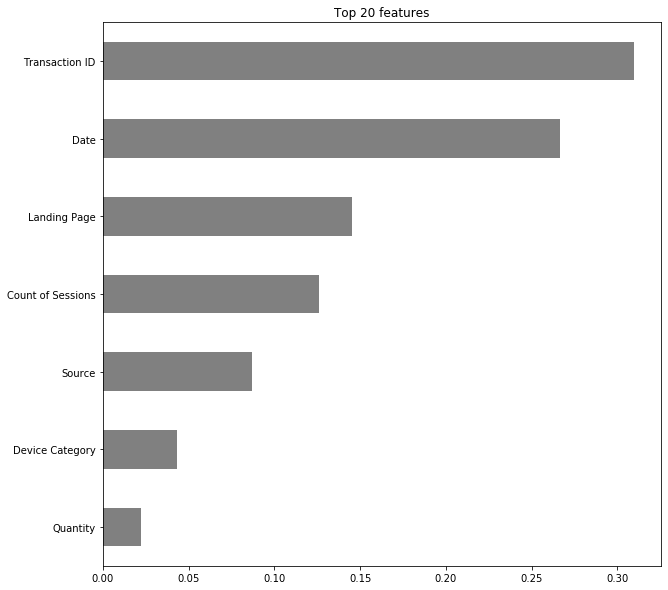

In [26]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Permutation Importances

In [27]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [28]:
# Ignore warnings

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test_transformed, y_test)

/Users/willsn/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/willsn/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [29]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Date                -0.043088
Transaction ID      -0.039298
Count of Sessions   -0.035509
Source              -0.035509
Landing Page        -0.035509
Device Category     -0.022737
Quantity             0.006456
dtype: float64

In [30]:
type(feature_names)

list

In [31]:

eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names) # must be a list


###Very similiar to the feature importances used in the decision tree.

Weight,Feature
0.0065 ± 0.0045,Quantity
-0.0227 ± 0.0059,Device Category
-0.0355 ± 0.0069,Landing Page
-0.0355 ± 0.0062,Source
-0.0355 ± 0.0045,Count of Sessions
-0.0393 ± 0.0111,Transaction ID
-0.0431 ± 0.0042,Date


In [32]:
### XG BOOST MODEL

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))



Test Accuracy 0.7698245614035087


# ROC/AUC

### This doesn't really make sense becuase I have a multi-class problem (can't make the curve). 

#### A confusion matrix would be better instead.

In [43]:
#from sklearn.metrics import roc_auc_score
#y_pred_proba = pipeline.predict_proba(X_train)[:, -1] # Probability for the last class
#roc_auc_score(y_train, y_pred_proba)

In [44]:
#from sklearn.metrics import roc_curve
#fpr, tpr, threshsolds = roc_curve(y_test, y_pred_proba)

## Confusion Matrix
#### Shows that my model is pretty much just predicting 'accessory'

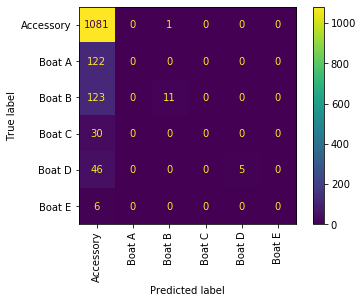

In [48]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_test, y_test, values_format='.0f', xticks_rotation='vertical');

# Partial dependence plot

In [50]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Date'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature)

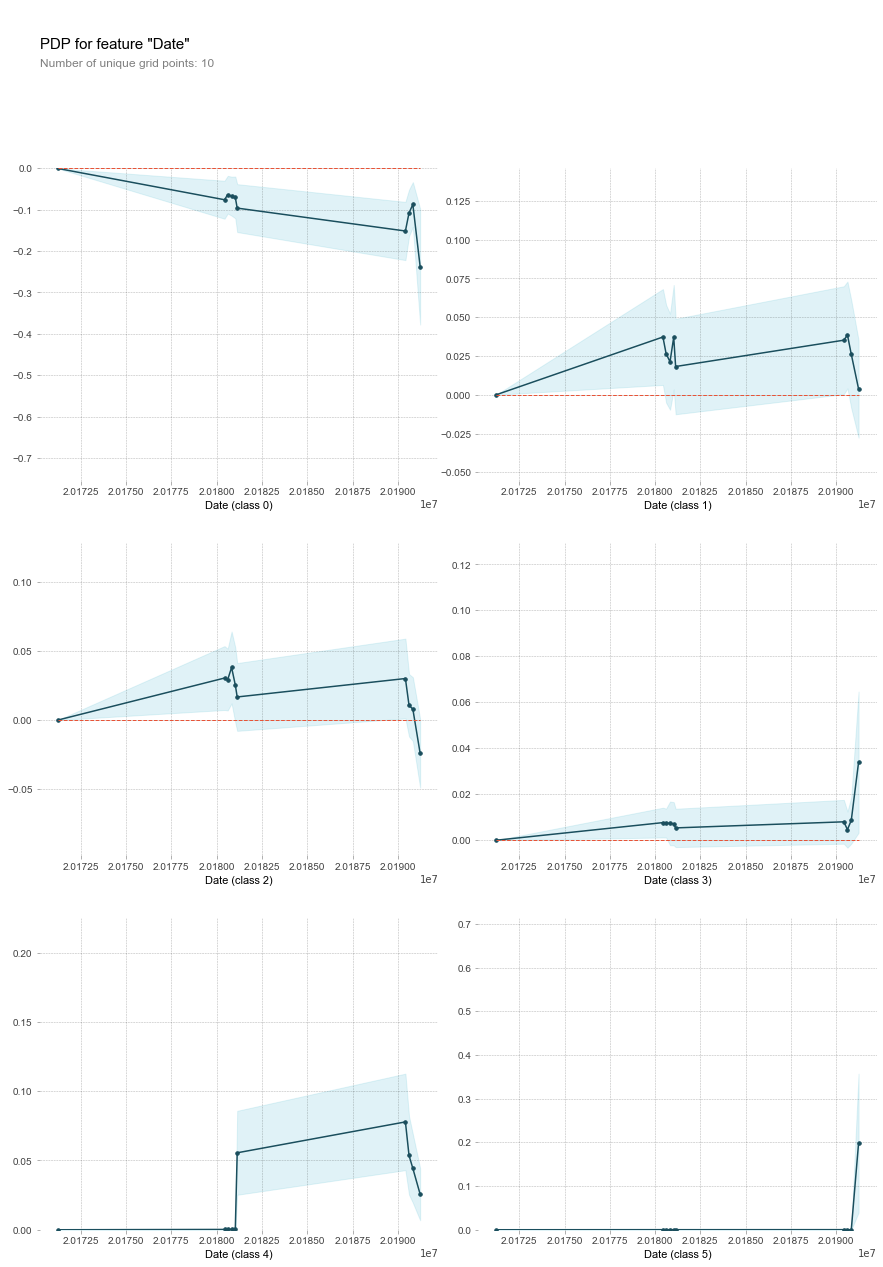

In [52]:
pdp_plot(isolated, feature_name=feature);

#### Cool! Looks a little chaotic though. I think there is some noise in my model due to some sub-par data wrangling.

#### The very last (bottom right) graph is cool though, becuase that product has only been on sale on the website for the last month or two. It's picking that up!


# Make at least 1 Shapley force plot to explain an individual prediction.

In [56]:
'''
import shap

explainer = shap.TreeExplainer(model)
row_processed = pipeline.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

'''

"\nimport shap\n\nexplainer = shap.TreeExplainer(model)\nrow_processed = pipeline.transform(row)\nshap_values = explainer.shap_values(row_processed)\n\nshap.initjs()\nshap.force_plot(\n    base_value=explainer.expected_value, \n    shap_values=shap_values, \n    features=row, \n    link='logit' # For classification, this shows predicted probabilities\n)\n\n"

In [ ]:
import shap
explainer = shap.TreeExplainer()

# Share at least 1 visualization (of any type) on Slack!

# TO DO // Checking my work

In [ ]:

### TODO ####

#### NEED CROSS VALIDATION IN THERE. RIGHT NOW I JUST HAVE TRAIN AND TEST.

## Double check my wrangling and cleaning functions to make sure that the buckets are accurate (consistent with the new metrics I just imported this evening)

### Could get twice as much data if I could figure out what's up with the 'Product Revenue' metric on Google Analytics

### Add in more features by exporting more csv's from Google Analytics

In [ ]:
#test_frame = df[df['Product']=='Boat A']

#test_frame['Product Revenue'].value_counts()

#### There are a few weird outliers, and quite a few where the person bought two boats. I need to find a way to split this into 2 seperate transactions.

In [ ]:
#test_frame = df[df['Product']=='Accessory']

#test_frame['Product Revenue'].value_counts(ascending=False) > 1000